## Get Dataset and Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -U FlagEmbedding -q
#import bull market data
# !git clone https://github.com/ShihChinYang2003/Compsci526_Team_Project.git
# %cd Compsci526_Team_Project

In [ ]:
import kagglehub

# Download CryptoNews+
# path = kagglehub.dataset_download("oliviervha/crypto-news")
# print("Path to crypto news dataset:", path)

# crypto_price_path = "/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/crypto prices/"
# Download historical price
crypto_price_path = kagglehub.dataset_download("svaningelgem/crypto-currencies-daily-prices")

print("Path to crypto price dataset:", crypto_price_path)

Using Colab cache for faster access to the 'crypto-currencies-daily-prices' dataset.
Path to crypto price dataset: /kaggle/input/crypto-currencies-daily-prices


In [ ]:
# =======================
# Step 1: Import Packages
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
from typing import Callable, Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import Model, regularizers, layers
from keras.layers import Input, LSTM, Dense, Dropout, SpatialDropout1D, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sentence_transformers import SentenceTransformer
import datetime
import ast # Import ast to safely evaluate the sentiment string
import warnings
import os, random
from tqdm import tqdm
# from FlagEmbedding import BGEM3FlagModel
warnings.filterwarnings("ignore")

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.backend.clear_session()

## Preprocessing

In [ ]:
combined_sentiment = pd.read_parquet("/content/drive/MyDrive/CS526_DS_Group/Text Model/text_dataset/combined_sentiment.parquet")
combined_sentiment.index = pd.to_datetime(combined_sentiment.index)

combined_embeddings = pd.read_parquet("/content/drive/MyDrive/CS526_DS_Group/Text Model/text_dataset/combined_news_with_bge_m3.parquet")
combined_embeddings.index = pd.to_datetime(combined_embeddings.index)

Number of missing dates: 15
DatetimeIndex(['2021-01-08', '2021-01-09', '2021-01-14', '2021-01-18',
               '2021-01-19', '2021-01-23', '2021-01-26', '2021-01-30',
               '2021-03-18', '2021-03-27', '2021-07-13', '2021-07-31',
               '2022-01-02', '2022-01-09', '2022-01-16'],
              dtype='datetime64[ns]', freq=None)


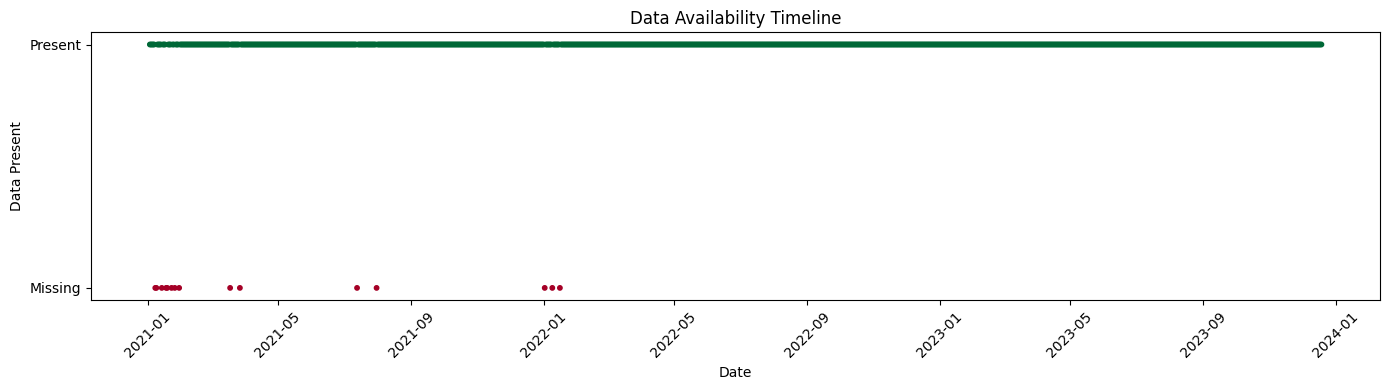

In [ ]:
full_range = pd.date_range(start=combined_sentiment.index.min(), end=combined_sentiment.index.max(), freq="D")
missing_dates = full_range.difference(combined_sentiment.index)
print("Number of missing dates:", len(missing_dates))
print(missing_dates)

presence = [1 if date in combined_sentiment.index else 0 for date in full_range]

fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(full_range, presence, c=presence, cmap='RdYlGn', s=10)
ax.set_xlabel('Date')
ax.set_ylabel('Data Present')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Missing', 'Present'])
ax.set_title('Data Availability Timeline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Crypto Price Data

In [ ]:
bitcoin_price_path = crypto_price_path + "/BTC.csv"
price = pd.read_csv(bitcoin_price_path, index_col='date', parse_dates=True)
close_price = price["close"]
daily_pct_change = price['close'].pct_change().rename("daily_pct_change", inplace=True)

# 計算每日報酬率
return_price = close_price.pct_change()
# Label：1 表示上漲，0 表示下跌
labels = (return_price > 0).astype(int)

### text embedding

In [ ]:

# @title
# model_name = "BAAI/bge-m3"
# model = BGEM3FlagModel(model_name, use_fp16=True)

# # Configuration
# BATCH_SIZE = 32
# MAX_LEN = 8192
# NORMALIZE = True

# # Encode all texts at once
# def encode_text(texts, filename):
#     all_texts = texts["text"].tolist()
#     out = model.encode(
#         all_texts,
#         batch_size=BATCH_SIZE,
#         max_length=MAX_LEN
#     )

#     # Get and normalize embeddings
#     dense_vecs = np.asarray(out["dense_vecs"], dtype="float32")
#     if NORMALIZE:
#         dense_vecs /= (np.linalg.norm(dense_vecs, axis=1, keepdims=True) + 1e-12)

#     # Save to parquet with dates
#     dates = texts.index.astype(str).to_numpy()
#     df_emb = pd.DataFrame(
#         {"date": dates, "embedding": list(dense_vecs)}
#     ).set_index("date")

#     df_emb.to_parquet(filename)
#     print(f"Done: {dense_vecs.shape}")

# encode_text(daily_text, "daily_news_with_bge_m3.parquet")
# encode_text(daily_text_bull, "daily_news_bull_with_bge_m3.parquet")


### Index data
Twitter Uncertainty Index and Fear & greed Index

In [ ]:
exog_data = pd.read_csv("/content/drive/MyDrive/CS526_DS_Group/Numeric Model/datasets/combined_index_data.csv", index_col='date', parse_dates=True)
index_data = exog_data[['fng_value', 'TEU-ENG']]
index_data.head()

,fng_value,TEU-ENG
date,,
2021-01-01,94,110.255460
2021-01-02,94,163.716142
2021-01-03,93,202.245936
2021-01-04,94,150.834486
2021-01-05,93,148.794724


In [ ]:
print(f"index data range: {index_data.index.min()} to {index_data.index.max()}")

index data range: 2021-01-01 00:00:00 to 2023-04-21 00:00:00


### Format Data

In [ ]:
# @title
def formatData(X, y, window_size=7):
    assert(window_size > 0)
    X_formatted, y_formatted = [], []

    for i in range(window_size, len(X)-1):
        X_formatted.append(X[i-window_size:i])  # 過去 n 天所有特徵
        y_formatted.append(y[i])                      # 預測第 i+1 天漲跌

    X_formatted = np.array(X_formatted)
    y_formatted = np.array(y_formatted)
    return (X_formatted, y_formatted)

def prepare_timeseries_data(
    labels,
    window_size,
    daily_sentiment=None,
    daily_text=None,
    index_data=None,
    daily_pct_change=None,
    train_size=0.7,
    dev_size=0.1,
    test_size=0.2
):
    """
    Prepare time series data for model training with train/dev/test splits.

    Parameters:
    -----------
    labels : pd.Series or pd.DataFrame
        Target labels with datetime index
    window_size : int
        Number of timesteps to use for sequence creation
    daily_sentiment : pd.DataFrame, optional
        Contains 'sentiment' and 'post_count' columns
    daily_text : pd.DataFrame, optional
        Contains 'embedding' column (will NOT be scaled)
    index_data : pd.DataFrame, optional
        Contains 'fng_value' and 'TEU-ENG' columns
    daily_pct_change : pd.DataFrame, optional
        Contains 'daily_pct_change' column
    train_size : float, default=0.7
        Proportion of data for training
    dev_size : float, default=0.1
        Proportion of data for development/validation
    test_size : float, default=0.2
        Proportion of data for testing

    Returns:
    --------
    X_train, y_train, X_dev, y_dev, X_test, y_test : np.ndarray
        Preprocessed and windowed data splits
    """

    # Collect all non-None dataframes
    dataframes = []
    df_names = []

    if daily_sentiment is not None:
        dataframes.append(daily_sentiment)
        df_names.append('daily_sentiment')
    if daily_text is not None:
        dataframes.append(daily_text)
        df_names.append('daily_text')
    if index_data is not None:
        dataframes.append(index_data)
        df_names.append('index_data')
    if daily_pct_change is not None:
        dataframes.append(daily_pct_change)
        df_names.append('daily_pct_change')

    if not dataframes:
        raise ValueError("At least one data source must be provided")

    # Find common dates across all dataframes and labels
    common_dates = labels.index
    for df in dataframes:
        common_dates = common_dates.intersection(df.index)

    print(f"Number of common dates: {len(common_dates)}")

    # Filter all dataframes to common dates
    labels_filtered = labels.loc[common_dates]

    # Build list of filtered dataframes to concatenate
    filtered_dfs = []
    cols_to_scale = []

    if daily_sentiment is not None:
        daily_sentiment_filtered = daily_sentiment.loc[common_dates]
        filtered_dfs.append(daily_sentiment_filtered)
        cols_to_scale.extend(['sentiment', 'post_count'])

    if index_data is not None:
        index_data_filtered = index_data.loc[common_dates]
        filtered_dfs.append(index_data_filtered)
        cols_to_scale.extend(['fng_value', 'TEU-ENG'])

    if daily_pct_change is not None:
        daily_pct_change_filtered = daily_pct_change.loc[common_dates]
        filtered_dfs.append(daily_pct_change_filtered)
        cols_to_scale.append('daily_pct_change')

    if daily_text is not None:
        daily_text_filtered = daily_text.loc[common_dates]
        # Only add embedding column, don't scale it
        filtered_dfs.append(daily_text_filtered[['embedding']])

    # Concatenate all data
    daily_data_filtered = pd.concat(filtered_dfs, axis=1)
    print(f"Combined features: {list(daily_data_filtered.columns)}")

    # Split data: train / temp (dev + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        daily_data_filtered, labels_filtered,
        test_size=(dev_size + test_size),
        shuffle=False
    )

    # Split temp into dev and test
    dev_proportion = dev_size / (dev_size + test_size)
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - dev_proportion),
        shuffle=False
    )

    # Verify splits
    total = len(daily_data_filtered)
    print(f"Train set size: {len(X_train)} ({len(X_train)/total*100:.1f}%)")
    print(f"Dev set size:   {len(X_dev)} ({len(X_dev)/total*100:.1f}%)")
    print(f"Test set size:  {len(X_test)} ({len(X_test)/total*100:.1f}%)")

    # Scale features (excluding embedding)
    scaler = StandardScaler()

    # Make copies
    X_train_scaled = X_train.copy()
    X_dev_scaled = X_dev.copy()
    X_test_scaled = X_test.copy()

    # Fit scaler ONLY on training data
    scaler.fit(X_train[cols_to_scale])

    # Transform all splits
    X_train_scaled.loc[:, cols_to_scale] = scaler.transform(X_train[cols_to_scale])
    X_dev_scaled.loc[:, cols_to_scale] = scaler.transform(X_dev[cols_to_scale])
    X_test_scaled.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    # Convert to numpy arrays (handle embedding arrays properly)
    X_train_scaled = np.hstack([
        np.vstack(X_train_scaled[col].values) for col in X_train_scaled.columns
    ])
    X_dev_scaled = np.hstack([
        np.vstack(X_dev_scaled[col].values) for col in X_dev_scaled.columns
    ])
    X_test_scaled = np.hstack([
        np.vstack(X_test_scaled[col].values) for col in X_test_scaled.columns
    ])

    print(f"\nAfter numpy conversion:")
    print(f"X_train shape: {X_train_scaled.shape}")
    print(f"X_dev shape:   {X_dev_scaled.shape}")
    print(f"X_test shape:  {X_test_scaled.shape}")

    # Apply windowing (assumes formatData function exists)
    X_train_windowed, y_train_windowed = formatData(X_train_scaled, y_train, window_size)
    X_dev_windowed, y_dev_windowed = formatData(X_dev_scaled, y_dev, window_size)
    X_test_windowed, y_test_windowed = formatData(X_test_scaled, y_test, window_size)

    print(f"\nAfter windowing (window_size={window_size}):")
    print(f"X_train shape: {X_train_windowed.shape}, y_train shape: {y_train_windowed.shape}")
    print(f"X_dev shape:   {X_dev_windowed.shape}, y_dev shape: {y_dev_windowed.shape}")
    print(f"X_test shape:  {X_test_windowed.shape}, y_test shape: {y_test_windowed.shape}")

    return X_train_windowed, y_train_windowed, X_dev_windowed, y_dev_windowed, X_test_windowed, y_test_windowed

### Threshold Picker Function

In [ ]:
# @title
def optimize_threshold(
    y_true: np.ndarray,
    y_probs: np.ndarray,
    metric: str = 'f1',
    thresholds: np.ndarray = None,
    return_scores: bool = False,
    plot: bool = False
) -> Tuple[float, float] | Tuple[float, float, Dict]:
    """
    Find the optimal classification threshold for a binary classifier.

    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_probs : array-like
        Predicted probabilities for the positive class
    metric : str, default='f1'
        Metric to optimize. Options: 'f1', 'accuracy', 'precision', 'recall'
    thresholds : array-like, optional
        Array of thresholds to try. If None, uses np.arange(0.01, 1.0, 0.01)
    return_scores : bool, default=False
        If True, returns all threshold scores
    plot : bool, default=False
        If True, plots metric vs threshold

    Returns:
    --------
    optimal_threshold : float
        The threshold that maximizes the metric
    best_score : float
        The best metric score achieved
    all_scores : dict (optional)
        Dictionary with thresholds and scores if return_scores=True

    Example:
    --------
    >>> y_probs = model.predict_proba(X_val)[:, 1]
    >>> threshold, score = optimize_threshold(y_val, y_probs, metric='f1')
    >>> print(f"Optimal threshold: {threshold:.3f}, F1 score: {score:.3f}")
    """

    # Default thresholds if not provided
    if thresholds is None:
        thresholds = np.arange(0.01, 1.0, 0.01)

    # Select metric function
    metric_functions = {
        'f1': f1_score,
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score
    }

    if metric not in metric_functions:
        raise ValueError(f"Metric must be one of {list(metric_functions.keys())}")

    metric_func = metric_functions[metric]

    # Calculate scores for each threshold
    scores = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        score = metric_func(y_true, y_pred)
        scores.append(score)

    scores = np.array(scores)

    # Find optimal threshold
    best_idx = np.argmax(scores)
    optimal_threshold = thresholds[best_idx]
    best_score = scores[best_idx]

    # Plot if requested
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(thresholds, scores, linewidth=2)
        plt.axvline(optimal_threshold, color='r', linestyle='--',
                   label=f'Optimal threshold: {optimal_threshold:.3f}')
        plt.axhline(best_score, color='g', linestyle='--', alpha=0.3,
                   label=f'Best {metric}: {best_score:.4f}')
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel(f'{metric.capitalize()} Score', fontsize=12)
        plt.title(f'{metric.capitalize()} vs Threshold', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Return results
    if return_scores:
        all_scores = {
            'thresholds': thresholds,
            'scores': scores
        }
        return optimal_threshold, best_score, all_scores

    return optimal_threshold, best_score


def evaluate_at_threshold(
    y_true: np.ndarray,
    y_probs: np.ndarray,
    threshold: float = 0.5,
    print_results: bool = True
) -> Dict[str, float]:
    """
    Evaluate all common metrics at a given threshold.

    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_probs : array-like
        Predicted probabilities
    threshold : float
        Classification threshold
    print_results : bool, default=True
        If True, prints formatted results

    Returns:
    --------
    metrics : dict
        Dictionary of metric names and values
    """
    y_pred = (y_probs >= threshold).astype(int)
    report_dict = classification_report(y_true, y_pred, digits=4,output_dict=True)
    if print_results:
        print("=" * 50)
        print(f"Classification Metrics (threshold={threshold:.3f})")
        print("=" * 50)
        print(classification_report(y_true, y_pred, digits=4))
        print("=" * 50)
    return report_dict

def pick_threshold(y_test, y_test_probs, metric="accuracy", plot=True):
    threshold, score = optimize_threshold(y_test, y_test_probs, metric, plot=plot)
    evaluate_at_threshold(y_test, y_test_probs, threshold, print_results=plot)
    return threshold

## LSTM Model

In [ ]:
# @title
def train_eval_lstm(
    X_train, y_train,
    X_dev, y_dev,  # Changed from X_test, y_test
    lstm_units=48,
    dense_units=32,
    drop_in=0.10,           # SpatialDropout1D on inputs (drops whole features across all timesteps)
    drop_lstm=0.20,         # input dropout inside LSTM; recurrent dropout = drop_lstm/2
    drop_dense=0.20,        # between Dense layers, not after final sigmoid
    l2w=1e-4,               # L2 weight decay
    lr=3e-4,
    batch_size=16,
    epochs=50,
    val_split=0.20,         # chronological validation split from the tail of training set
    patience_es=7,
    patience_rlrop=3,
    min_lr=1e-6,
    threshold=0.5,          # decision threshold for classification
    class_weight=None,      # e.g., {0:1.0, 1: (len(y_train)/(2*np.sum(y_train)))}
    plot=True,
    seed=42
):
    """
    Trains an LSTM binary classifier on time-series windows shaped (T, F),
    prints classification reports on train and dev, and returns (model, history, y_probs).
    Assumes X_* shapes are (n_samples, timesteps, n_features), y_* shape is (n_samples,).
    """
    set_seed(seed)

    # ----- model -----
    timesteps, n_features = X_train.shape[1], X_train.shape[2]
    model = Sequential([
        Input(shape=(timesteps, n_features)),
        SpatialDropout1D(drop_in),
        LSTM(
            lstm_units,
            dropout=drop_lstm,
            recurrent_dropout=drop_lstm/2,
            kernel_regularizer=regularizers.l2(l2w),
            recurrent_regularizer=regularizers.l2(l2w)
        ),
        LayerNormalization(),
        Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
        Dropout(drop_dense),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    # ----- callbacks -----
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=patience_es,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=patience_rlrop,
            min_lr=min_lr
        )
    ]

    # ----- training -----
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        shuffle=False,
        verbose=0,
        callbacks=callbacks,
        class_weight=class_weight
    )

    # ----- evaluation -----
    # Get predictions
    y_train_prob = model.predict(X_train, verbose=0).ravel()
    y_dev_prob = model.predict(X_dev, verbose=0).ravel()  # Changed from y_test_prob

    y_train_pred = (y_train_prob > threshold).astype(int)
    y_dev_pred = (y_dev_prob > threshold).astype(int)  # Changed from y_test_pred

    # Print classification reports
    print("\n" + "="*50)
    print("TRAINING SET EVALUATION")
    print("="*50)
    print(classification_report(y_train, y_train_pred, digits=4))

    print("\n" + "="*50)
    print("DEV SET EVALUATION")  # Changed from TEST SET
    print("="*50)
    print(classification_report(y_dev, y_dev_pred, digits=4))  # Changed from y_test

    # ----- plot -----
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Binary Crossentropy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Store probabilities
    y_probs = {
        'train': y_train_prob,
        'dev': y_dev_prob  # Changed from 'test'
    }

    return model, history, y_probs

### LSTM with sentiment + text (7 days)

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test = prepare_timeseries_data(
    labels=labels,
    window_size=7,
    daily_sentiment=combined_sentiment,
    daily_text=combined_embeddings
)


Number of common dates: 1066
Combined features: ['sentiment', 'post_count', 'embedding']
Train set size: 746 (70.0%)
Dev set size:   106 (9.9%)
Test set size:  214 (20.1%)

After numpy conversion:
X_train shape: (746, 1026)
X_dev shape:   (106, 1026)
X_test shape:  (214, 1026)

After windowing (window_size=7):
X_train shape: (738, 7, 1026), y_train shape: (738,)
X_dev shape:   (98, 7, 1026), y_dev shape: (98,)
X_test shape:  (206, 7, 1026), y_test shape: (206,)



TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5382    0.8000    0.6435       370
           1     0.6064    0.3098    0.4101       368

    accuracy                         0.5556       738
   macro avg     0.5723    0.5549    0.5268       738
weighted avg     0.5722    0.5556    0.5271       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5275    0.9231    0.6713        52
           1     0.4286    0.0652    0.1132        46

    accuracy                         0.5204        98
   macro avg     0.4780    0.4941    0.3923        98
weighted avg     0.4810    0.5204    0.4094        98



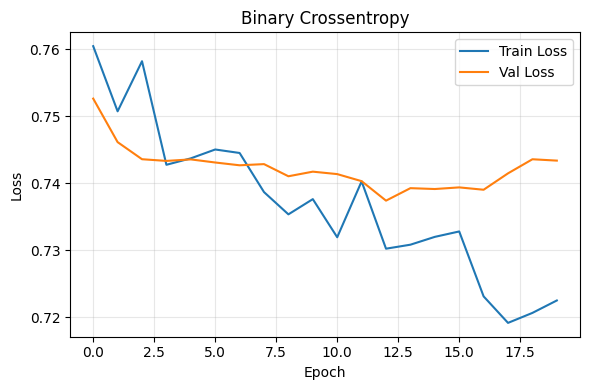

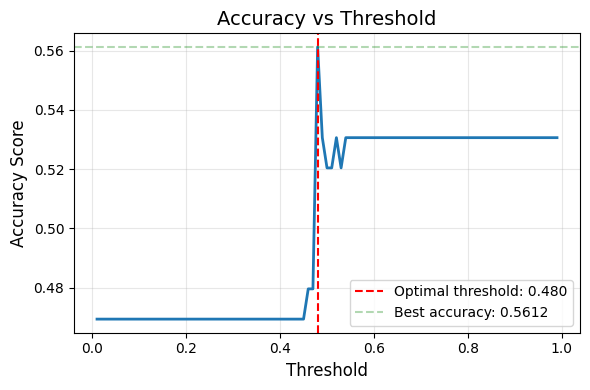

Classification Metrics (threshold=0.480)
              precision    recall  f1-score   support

           0     0.7647    0.2500    0.3768        52
           1     0.5185    0.9130    0.6614        46

    accuracy                         0.5612        98
   macro avg     0.6416    0.5815    0.5191        98
weighted avg     0.6491    0.5612    0.5104        98


TEST SET EVALUATION
Classification Metrics (threshold=0.480)
              precision    recall  f1-score   support

           0     0.4375    0.3500    0.3889       100
           1     0.4841    0.5755    0.5259       106

    accuracy                         0.4660       206
   macro avg     0.4608    0.4627    0.4574       206
weighted avg     0.4615    0.4660    0.4594       206



In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_dev, y_dev,
    lstm_units=64, dense_units=16, lr=1e-4,
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5985    0.6568    0.6263       370
           1     0.6175    0.5571    0.5857       368

    accuracy                         0.6070       738
   macro avg     0.6080    0.6069    0.6060       738
weighted avg     0.6080    0.6070    0.6061       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5513    0.8269    0.6615        52
           1     0.5500    0.2391    0.3333        46

    accuracy                         0.5510        98
   macro avg     0.5506    0.5330    0.4974        98
weighted avg     0.5507    0.5510    0.5075        98



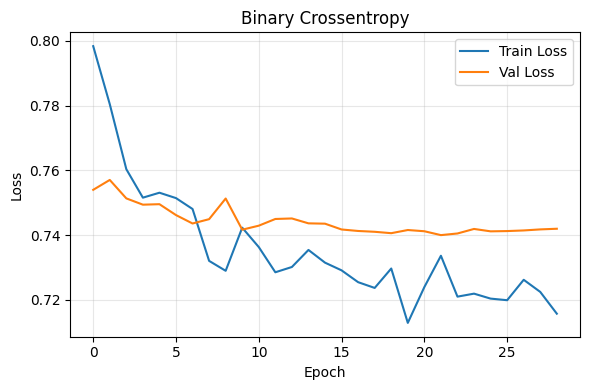

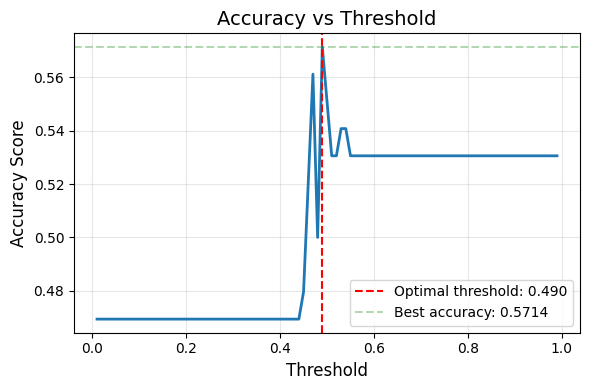

Classification Metrics (threshold=0.490)
              precision    recall  f1-score   support

           0     0.5806    0.6923    0.6316        52
           1     0.5556    0.4348    0.4878        46

    accuracy                         0.5714        98
   macro avg     0.5681    0.5635    0.5597        98
weighted avg     0.5689    0.5714    0.5641        98


TEST SET EVALUATION
Classification Metrics (threshold=0.490)
              precision    recall  f1-score   support

           0     0.5455    0.7200    0.6207       100
           1     0.6216    0.4340    0.5111       106

    accuracy                         0.5728       206
   macro avg     0.5835    0.5770    0.5659       206
weighted avg     0.5846    0.5728    0.5643       206



In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_dev, y_dev,
    lstm_units=64, dense_units=32, lr=1e-4,
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.7525    0.4108    0.5315       370
           1     0.5933    0.8641    0.7035       368

    accuracy                         0.6369       738
   macro avg     0.6729    0.6375    0.6175       738
weighted avg     0.6731    0.6369    0.6173       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.4889    0.4231    0.4536        52
           1     0.4340    0.5000    0.4646        46

    accuracy                         0.4592        98
   macro avg     0.4614    0.4615    0.4591        98
weighted avg     0.4631    0.4592    0.4588        98



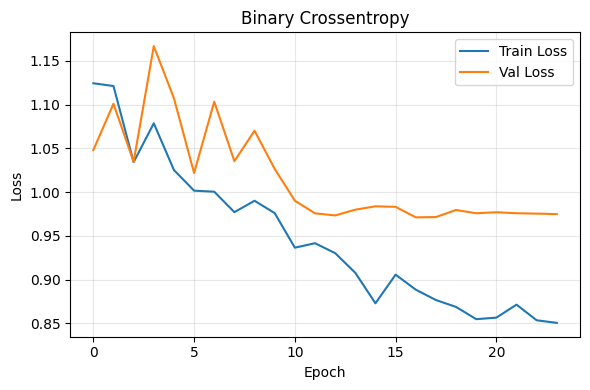

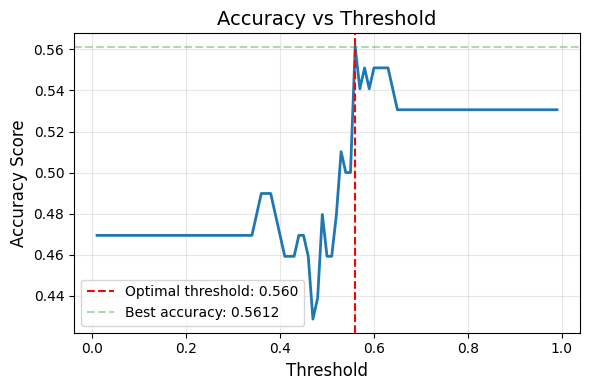

Classification Metrics (threshold=0.560)
              precision    recall  f1-score   support

           0     0.5570    0.8462    0.6718        52
           1     0.5789    0.2391    0.3385        46

    accuracy                         0.5612        98
   macro avg     0.5680    0.5426    0.5051        98
weighted avg     0.5673    0.5612    0.5153        98


TEST SET EVALUATION
Classification Metrics (threshold=0.560)
              precision    recall  f1-score   support

           0     0.4943    0.4300    0.4599       100
           1     0.5210    0.5849    0.5511       106

    accuracy                         0.5097       206
   macro avg     0.5076    0.5075    0.5055       206
weighted avg     0.5080    0.5097    0.5068       206



In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_dev, y_dev,
    lstm_units=1024, dense_units=512, lr=1e-4,
    drop_in=0.3, drop_lstm=0.25, drop_dense=0.
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5579    0.6378    0.5952       370
           1     0.5746    0.4918    0.5300       368

    accuracy                         0.5650       738
   macro avg     0.5663    0.5648    0.5626       738
weighted avg     0.5662    0.5650    0.5627       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5932    0.6731    0.6306        52
           1     0.5641    0.4783    0.5176        46

    accuracy                         0.5816        98
   macro avg     0.5787    0.5757    0.5741        98
weighted avg     0.5796    0.5816    0.5776        98



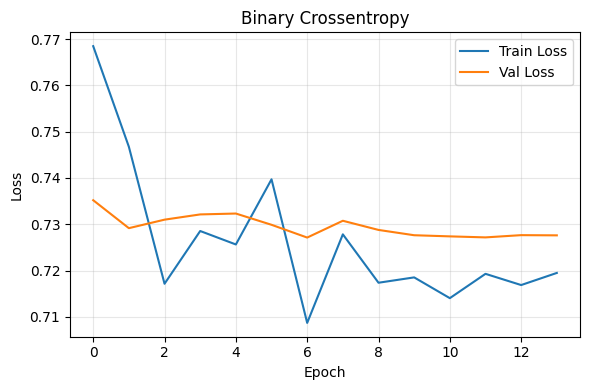

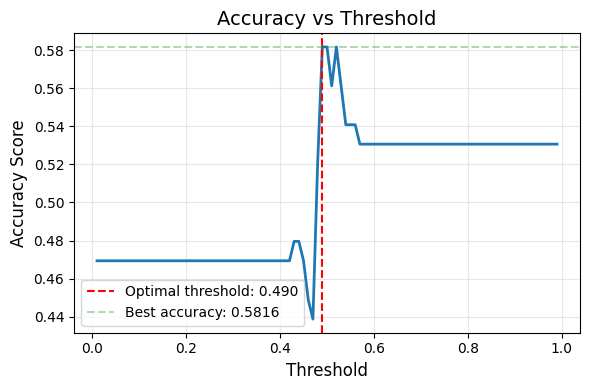

Classification Metrics (threshold=0.490)
              precision    recall  f1-score   support

           0     0.6222    0.5385    0.5773        52
           1     0.5472    0.6304    0.5859        46

    accuracy                         0.5816        98
   macro avg     0.5847    0.5844    0.5816        98
weighted avg     0.5870    0.5816    0.5813        98


TEST SET EVALUATION
Classification Metrics (threshold=0.490)
              precision    recall  f1-score   support

           0     0.5000    0.4700    0.4845       100
           1     0.5268    0.5566    0.5413       106

    accuracy                         0.5146       206
   macro avg     0.5134    0.5133    0.5129       206
weighted avg     0.5138    0.5146    0.5137       206



In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_dev, y_dev,
    lstm_units=32, dense_units=32
    , lr=1e-4,
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

### LSTM hybrid (7 day)

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test = prepare_timeseries_data(
    labels=labels,
    window_size=7,
    daily_sentiment=combined_sentiment,
    daily_text=combined_embeddings,
    index_data=index_data,
    daily_pct_change=daily_pct_change
)

In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_dev, y_dev,
    lstm_units=8, dense_units=8
    , lr=1e-4,
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

In [ ]:
model, history, y_probs = train_eval_lstm(
    X_train, y_train, X_test, y_test,
    lstm_units=16, dense_units=8
    , lr=1e-4,
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

## Transformer Model

In [ ]:


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(attn_output)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dense(inputs.shape[-1])(x)
    x = layers.Dropout(dropout)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)

def train_and_evaluate_transformer(
    X_train, y_train, X_dev, y_dev,
    input_shape=None,
    head_size=8,
    num_heads=2,
    ff_dim=16,
    num_transformer_blocks=1,
    mlp_units=[8],
    dropout=0.3,
    mlp_dropout=0.3,
    learning_rate=1e-4,
    epochs=500,
    batch_size=16,
    validation_split=0.2,
    patience_es=10,  # Renamed for clarity
    patience_rlrop=3,  # Added for ReduceLROnPlateau
    min_lr=1e-6,  # Added for ReduceLROnPlateau
    seed=42,
    plot=True
):
    """
    Train and evaluate a transformer model for binary classification.

    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_dev, y_dev : Dev data and labels (for validation)
    input_shape : tuple, optional. If None, inferred from X_train
    head_size : int, attention head size
    num_heads : int, number of attention heads
    ff_dim : int, feed-forward dimension
    num_transformer_blocks : int, number of transformer blocks
    mlp_units : list, MLP layer sizes
    dropout : float, dropout rate
    mlp_dropout : float, MLP dropout rate
    learning_rate : float, learning rate for optimizer
    epochs : int, maximum number of epochs
    batch_size : int, batch size for training
    validation_split : float, validation split ratio
    patience_es : int, early stopping patience
    patience_rlrop : int, ReduceLROnPlateau patience
    min_lr : float, minimum learning rate for ReduceLROnPlateau
    seed: int, random seed
    plot : bool, whether to plot training history

    Returns:
    --------
    model : trained Keras model
    history : training history object
    y_probs : dict with 'train' and 'dev' prediction probabilities
    """
    set_seed(seed)

    if input_shape is None:
        input_shape = (X_train.shape[1], X_train.shape[2])

    print(f"Transformer Setup: {num_transformer_blocks} blocks | {num_heads} heads (size {head_size}) | FF dim {ff_dim}")
    print(f"Data: Train {X_train.shape[0]} | Dev {X_dev.shape[0]} | Input shape {input_shape}")  # Changed from Test
    print(f"Training: LR {learning_rate} | Batch {batch_size} | Epochs {epochs} (ES patience {patience_es}, RLROP patience {patience_rlrop})")
    print(f"Regularization: Dropout {dropout} | MLP dropout {mlp_dropout} | MLP units {mlp_units}")
    print(f"Seed: {seed}\n")

    # Build callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=patience_es,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=patience_rlrop,
            min_lr=min_lr,
            verbose=0
        )
    ]

    # Build the model
    model = build_transformer_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout,
        mlp_dropout
    )

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False,  # Added to match LSTM function (important for time series)
        verbose=0,
        callbacks=callbacks
    )

    # Get predictions
    y_train_probs = model.predict(X_train, verbose=0).flatten()
    y_dev_probs = model.predict(X_dev, verbose=0).flatten()  # Changed from y_test_probs

    y_train_pred = (y_train_probs > 0.5).astype(int)
    y_dev_pred = (y_dev_probs > 0.5).astype(int)  # Changed from y_test_pred

    # Print classification reports
    if plot:
        print("\n" + "="*50)
        print("TRAINING SET EVALUATION")
        print("="*50)
        print(classification_report(y_train, y_train_pred, digits=4))

        print("\n" + "="*50)
        print("DEV SET EVALUATION")  # Changed from TEST SET
        print("="*50)
        print(classification_report(y_dev, y_dev_pred, digits=4))  # Changed from y_test

    # Plot training history
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Transformer Model Loss (LR={learning_rate})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Store probabilities
    y_probs = {
        'train': y_train_probs,
        'dev': y_dev_probs  # Changed from 'test'
    }

    return model, history, y_probs

### Transformer with sentiment + text (7 day)

In [ ]:
X_train, y_train, X_dev, y_dev, X_test, y_test = prepare_timeseries_data(
    labels=labels,
    window_size=7,
    daily_sentiment=combined_sentiment,
    daily_text=combined_embeddings
)

Number of common dates: 1066
Combined features: ['sentiment', 'post_count', 'embedding']
Train set size: 746 (70.0%)
Dev set size:   106 (9.9%)
Test set size:  214 (20.1%)

After numpy conversion:
X_train shape: (746, 1026)
X_dev shape:   (106, 1026)
X_test shape:  (214, 1026)

After windowing (window_size=7):
X_train shape: (738, 7, 1026), y_train shape: (738,)
X_dev shape:   (98, 7, 1026), y_dev shape: (98,)
X_test shape:  (206, 7, 1026), y_test shape: (206,)


Transformer Setup: 1 blocks | 2 heads (size 8) | FF dim 8
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 | Epochs 500 (ES patience 10, RLROP patience 3)
Regularization: Dropout 0.3 | MLP dropout 0.3 | MLP units [8]
Seed: 42


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5285    0.6270    0.5735       370
           1     0.5385    0.4375    0.4828       368

    accuracy                         0.5325       738
   macro avg     0.5335    0.5323    0.5282       738
weighted avg     0.5335    0.5325    0.5283       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5658    0.8269    0.6719        52
           1     0.5909    0.2826    0.3824        46

    accuracy                         0.5714        98
   macro avg     0.5783    0.5548    0.5271        98
weighted avg     0.5776    0.5714    0.5360        98



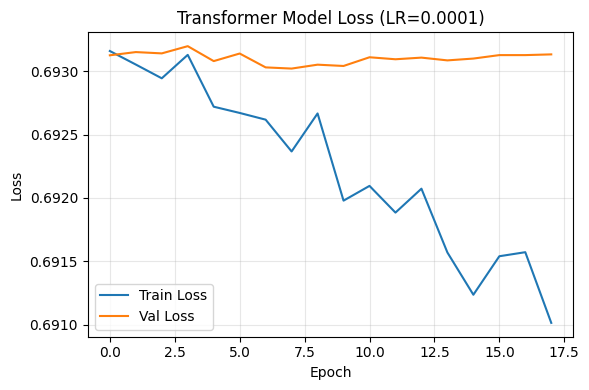

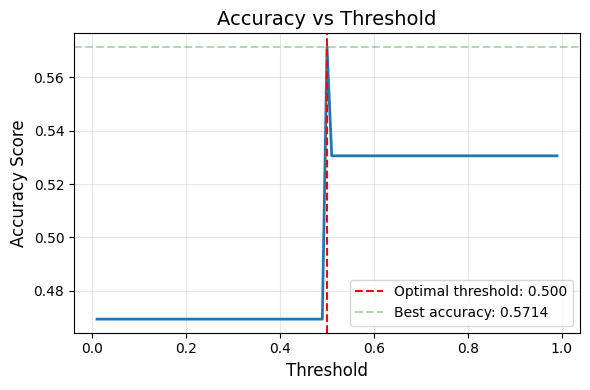

Classification Metrics (threshold=0.500)
              precision    recall  f1-score   support

           0     0.5658    0.8269    0.6719        52
           1     0.5909    0.2826    0.3824        46

    accuracy                         0.5714        98
   macro avg     0.5783    0.5548    0.5271        98
weighted avg     0.5776    0.5714    0.5360        98


TEST SET EVALUATION
Classification Metrics (threshold=0.500)
              precision    recall  f1-score   support

           0     0.5000    0.9700    0.6599       100
           1     0.7500    0.0849    0.1525       106

    accuracy                         0.5146       206
   macro avg     0.6250    0.5275    0.4062       206
weighted avg     0.6286    0.5146    0.3988       206



In [ ]:
model, history, y_probs = train_and_evaluate_transformer(
    X_train, y_train, X_dev, y_dev,
    learning_rate=1e-4,
    epochs=500,
    head_size=8,
    num_heads=2,
    ff_dim=8,
    mlp_units=[8],
    num_transformer_blocks=1,
    plot=True
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

Transformer Setup: 2 blocks | 4 heads (size 8) | FF dim 16
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 | Epochs 500 (ES patience 10, RLROP patience 3)
Regularization: Dropout 0.3 | MLP dropout 0.3 | MLP units [16]
Seed: 42


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5665    0.7595    0.6490       370
           1     0.6322    0.4158    0.5016       368

    accuracy                         0.5881       738
   macro avg     0.5994    0.5876    0.5753       738
weighted avg     0.5993    0.5881    0.5755       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5393    0.9231    0.6809        52
           1     0.5556    0.1087    0.1818        46

    accuracy                         0.5408        98
   macro avg     0.5474    0.5159    0.4313        98
weighted avg     0.5469    0.5408    0.4466        98



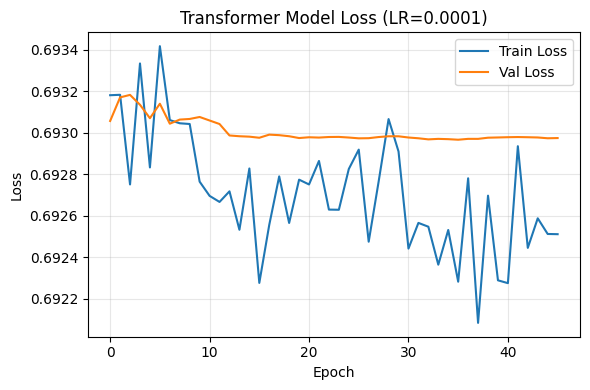

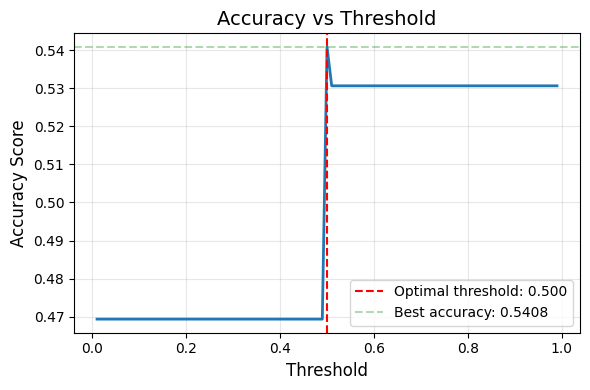

Classification Metrics (threshold=0.500)
              precision    recall  f1-score   support

           0     0.5393    0.9231    0.6809        52
           1     0.5556    0.1087    0.1818        46

    accuracy                         0.5408        98
   macro avg     0.5474    0.5159    0.4313        98
weighted avg     0.5469    0.5408    0.4466        98


TEST SET EVALUATION
Classification Metrics (threshold=0.500)
              precision    recall  f1-score   support

           0     0.4972    0.8800    0.6354       100
           1     0.5862    0.1604    0.2519       106

    accuracy                         0.5097       206
   macro avg     0.5417    0.5202    0.4436       206
weighted avg     0.5430    0.5097    0.4380       206



In [ ]:
model, history, y_probs = train_and_evaluate_transformer(
    X_train, y_train, X_dev, y_dev,
    learning_rate=1e-4,
    head_size=8,
    num_heads=4,
    ff_dim=16,
    mlp_units=[16],
    num_transformer_blocks=2,
    plot=True
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

Transformer Setup: 2 blocks | 2 heads (size 8) | FF dim 32
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 | Epochs 500 (ES patience 10, RLROP patience 3)
Regularization: Dropout 0.3 | MLP dropout 0.3 | MLP units [8]
Seed: 42


TRAINING SET EVALUATION
              precision    recall  f1-score   support

           0     0.5764    0.5811    0.5787       370
           1     0.5753    0.5707    0.5730       368

    accuracy                         0.5759       738
   macro avg     0.5759    0.5759    0.5759       738
weighted avg     0.5759    0.5759    0.5759       738


DEV SET EVALUATION
              precision    recall  f1-score   support

           0     0.5345    0.5962    0.5636        52
           1     0.4750    0.4130    0.4419        46

    accuracy                         0.5102        98
   macro avg     0.5047    0.5046    0.5027        98
weighted avg     0.5066    0.5102    0.5065        98



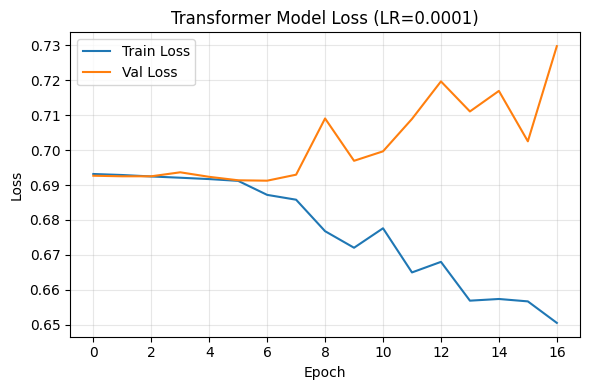

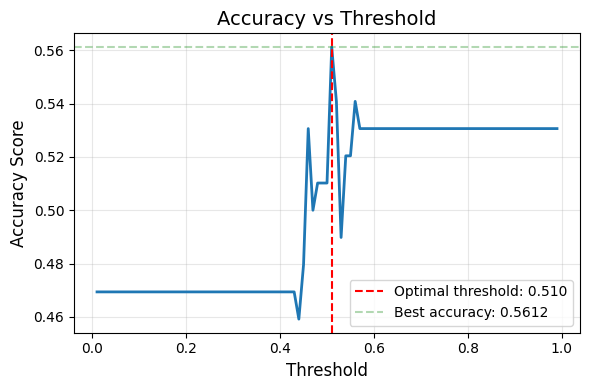

Classification Metrics (threshold=0.510)
              precision    recall  f1-score   support

           0     0.5672    0.7308    0.6387        52
           1     0.5484    0.3696    0.4416        46

    accuracy                         0.5612        98
   macro avg     0.5578    0.5502    0.5401        98
weighted avg     0.5584    0.5612    0.5461        98


TEST SET EVALUATION
Classification Metrics (threshold=0.510)
              precision    recall  f1-score   support

           0     0.5031    0.8200    0.6236       100
           1     0.5814    0.2358    0.3356       106

    accuracy                         0.5194       206
   macro avg     0.5422    0.5279    0.4796       206
weighted avg     0.5434    0.5194    0.4754       206



In [ ]:
model, history, y_probs = train_and_evaluate_transformer(
    X_train, y_train, X_dev, y_dev,
    learning_rate=1e-4,
    epochs=500,
    head_size=8,
    num_heads=2,
    ff_dim=32,
    mlp_units=[8],
    num_transformer_blocks=2,
    plot=True
)
threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy')
print("\n" + "="*50)
print("TEST SET EVALUATION")  # Changed from TEST SET
print("="*50)
results = evaluate_at_threshold(y_test, model.predict(X_test, verbose=0).ravel(), threshold)

In [ ]:
import itertools

def grid_search_transformer(X_train, y_train, X_dev, y_dev, X_test, y_test, param_grid):
    """
    Simple grid search for transformer hyperparameters.
    """
    # Create all combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(itertools.product(*param_values))

    print(f"Testing {len(param_combinations)} combinations\n")

    best_accuracy = -1
    best_params = None
    best_model = None
    best_threshold = None

    for idx, param_combo in enumerate(param_combinations, 1):
        params = dict(zip(param_names, param_combo))

        # Train model
        model, history, y_probs = train_and_evaluate_transformer(
            X_train, y_train, X_dev, y_dev,
            learning_rate=params['learning_rate'],
            head_size=params['head_size'],
            num_heads=params['num_heads'],
            ff_dim=params['ff_dim'],
            mlp_units=params['mlp_units'],
            num_transformer_blocks=params['num_transformer_blocks'],
            plot=False
        )

        # Get threshold and evaluate
        threshold = pick_threshold(y_dev, y_probs['dev'], metric='accuracy', plot=False)
        dev_results = evaluate_at_threshold(y_dev, y_probs['dev'], threshold, print_results=False)
        dev_accuracy = dev_results['accuracy']

        # Print result
        print(f"[{idx}/{len(param_combinations)}] {params}")
        print(f"Dev Accuracy: {dev_accuracy:.4f}\n")

        # Track best
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            best_params = params
            best_model = model
            best_threshold = threshold

    # Final test evaluation
    print("="*50)
    print(f"Best params: {best_params}")
    print(f"Best dev accuracy: {best_accuracy:.4f}")
    print("="*50)
    print("TEST SET EVALUATION")
    print("="*50)
    results = evaluate_at_threshold(y_test, best_model.predict(X_test, verbose=0).ravel(), best_threshold)

    return best_params, best_model, best_threshold


param_grid = {
    'learning_rate': [1e-4, 5e-4, 1e-3],
    'head_size': [64, 128, 256],  # Larger for 1024 features
    'num_heads': [4, 8, 16],  # More heads for larger feature dim
    'ff_dim': [128, 256, 512],  # Larger feed-forward dim
    'mlp_units': [[128], [256], [128, 64]],  # Larger MLP units
    'num_transformer_blocks': [1, 2, 3]
}

best_params, best_model, best_threshold = grid_search_transformer(
    X_train, y_train, X_dev, y_dev, X_test, y_test, param_grid
)

Testing 729 combinations

Transformer Setup: 1 blocks | 4 heads (size 64) | FF dim 128
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 | Epochs 500 (ES patience 10, RLROP patience 3)
Regularization: Dropout 0.3 | MLP dropout 0.3 | MLP units [128]
Seed: 42

[1/729] {'learning_rate': 0.0001, 'head_size': 64, 'num_heads': 4, 'ff_dim': 128, 'mlp_units': [128], 'num_transformer_blocks': 1}
Dev Accuracy: 0.5714

Transformer Setup: 2 blocks | 4 heads (size 64) | FF dim 128
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 | Epochs 500 (ES patience 10, RLROP patience 3)
Regularization: Dropout 0.3 | MLP dropout 0.3 | MLP units [128]
Seed: 42

[2/729] {'learning_rate': 0.0001, 'head_size': 64, 'num_heads': 4, 'ff_dim': 128, 'mlp_units': [128], 'num_transformer_blocks': 2}
Dev Accuracy: 0.5612

Transformer Setup: 3 blocks | 4 heads (size 64) | FF dim 128
Data: Train 738 | Dev 98 | Input shape (7, 1026)
Training: LR 0.0001 | Batch 16 |

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/functional_1/multi_head_attention_1_2/attention_output_1/MatMul/Sum_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-3643248488.py", line 71, in <cell line: 0>

  File "/tmp/ipython-input-3643248488.py", line 23, in grid_search_transformer

  File "/tmp/ipython-input-2332986806.py", line 130, in train_and_evaluate_transformer

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 78, in train_step

OOM when allocating tensor with shape[2101248] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/functional_1/multi_head_attention_1_2/attention_output_1/MatMul/Sum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_2600728]